In [1]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np

# Extracción de mediciónes
Para hacer las mediciónes físicas se usó un VNA de 2 puertos Rohde-Schwarz, ZNC3-2Port calibrado en un rango de frecuencias de $0.5$ a $1.5$ GHz.
Como el divisor de Wilkinson tiene 3 puertos, se reconstruye la matriz de parámetros S a través de 3 mediciónes hechas por separado.

La correspondencia puerto VNA -> puerto Wilkinson es:

| Archivo | Puerto VNA | Puerto Dispositivo |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

Finalmente tenemos otro archivo 4.s2p, el cual tiene el through entre los dos cables sin carga en el medio para ver el ripple inherente al instrumento / cables

Primero cargamos los cuatro archivos de mediciónes

In [2]:
m1 = rf.Network('mediciones/1.s2p')
m2 = rf.Network('mediciones/2.s2p')
m3 = rf.Network('mediciones/3.s2p')
m4 = rf.Network('mediciones/4.s2p')

Luego hacemos una red de tres puertos correspondiente al divisor de Wilkinson llamada `willkinson`

In [3]:
#Extraigo las frecuencias del primer archivo
freq = m1.frequency
#Genero matriz de ceros para inicializar red vacia
s_mat = np.zeros((len(freq), 3, 3), dtype=complex)
#Genero red vacia
wilkinson = rf.Network(frequency=freq, s=s_mat, z0=50, name='Wilkinson 3-port')

La notación para referirse a un parámetro S es `wilkinson.s[frec, Sa, Sb]`. Para operar sobre todas las frecuencias simplemente se trabaja en modo rango completo usando `wilkinson.s[: ,Sa, Sb]`. El indexado inicia en 0, no en 1, con lo cual para referirse, por ejemplo, al parámetro $S_{21}$ en todo el espectro de frecuencias disponibles se hace `wilkinson.s[:, 1, 0]`

Ahora vamos a mapear todos los parámetros almacenados en los archivos .s2p (cada uno correspondiente a una red de dos puertos especificada en tabla) a la red de tres puertos `wilkinson` correspondiente a nuestro divisor de potencia.

Para las mediciónes de transmisión, hay una sola opción en cada caso con lo cual simplemente se mapea del archivo s2p a la variable

In [4]:
# Archivo 1.s2p (m1): VNA p1 -> Dispositivo p2 | VNA p2 -> Dispositivo p3
wilkinson.s[:, 2, 1] = m1.s[:, 1, 0]  # S21 de m1 -> S32 del dispositivo (transmisión p2->p3)
wilkinson.s[:, 1, 2] = m1.s[:, 0, 1]  # S12 de m1 -> S23 del dispositivo (transmisión p3->p2)

# Archivo 2.s2p (m2): VNA p1 -> Dispositivo p1 | VNA p2 -> Dispositivo p2
wilkinson.s[:, 1, 0] = m2.s[:, 1, 0]  # S21 de m2 -> S21 del dispositivo (transmisión p1->p2)
wilkinson.s[:, 0, 1] = m2.s[:, 0, 1]  # S12 de m2 -> S12 del dispositivo (transmisión p2->p1)

# Archivo 3.s2p (m3): VNA p1 -> Dispositivo p1 | VNA p2 -> Dispositivo p3
wilkinson.s[:, 2, 0] = m3.s[:, 1, 0]  # S21 de m3 -> S31 del dispositivo (transmisión p1->p3)
wilkinson.s[:, 0, 2] = m3.s[:, 0, 1]  # S12 de m3 -> S13 del dispositivo (transmisión p3->p1)

Ahora las reflexiónes. Hay 2 mediciónes de cada una ya que cada puerto se usó en dos archivos diferentes. Al no tener información sobre cuál es más confiable, hacemos un promedio simple de todas las reflexiónes

In [5]:
# Reflexión S11 (promedio de m2 y m3)
aux = (m2.s[:, 0, 0] + m3.s[:, 0, 0]) / 2  # Promedio de S11 de m2 y S11 de m3
wilkinson.s[:, 0, 0] = aux  # S11 del dispositivo

# Reflexión S22 (promedio de m1 y m2)
aux = (m1.s[:, 0, 0] + m2.s[:, 1, 1]) / 2  # S11 de m1 -> S22, S22 de m2 -> S22
wilkinson.s[:, 1, 1] = aux  # S22 del dispositivo

# Reflexión S33 (promedio de m1 y m3)
aux = (m1.s[:, 1, 1] + m3.s[:, 1, 1]) / 2  # S22 de m1 -> S33, S22 de m3 -> S33
wilkinson.s[:, 2, 2] = aux  # S33 del dispositivo

Ahora el bloque `wilkinson` tiene la matriz completa de parámetros S extraidos mediante mediciónes.

# Ploteos
Ploteamos transferencia, adaptación y aislación en tres gráficos separados desde función hecha a parte para simplificar y estandarizar ploteos

In [6]:
from plotear import plot_s_parameters

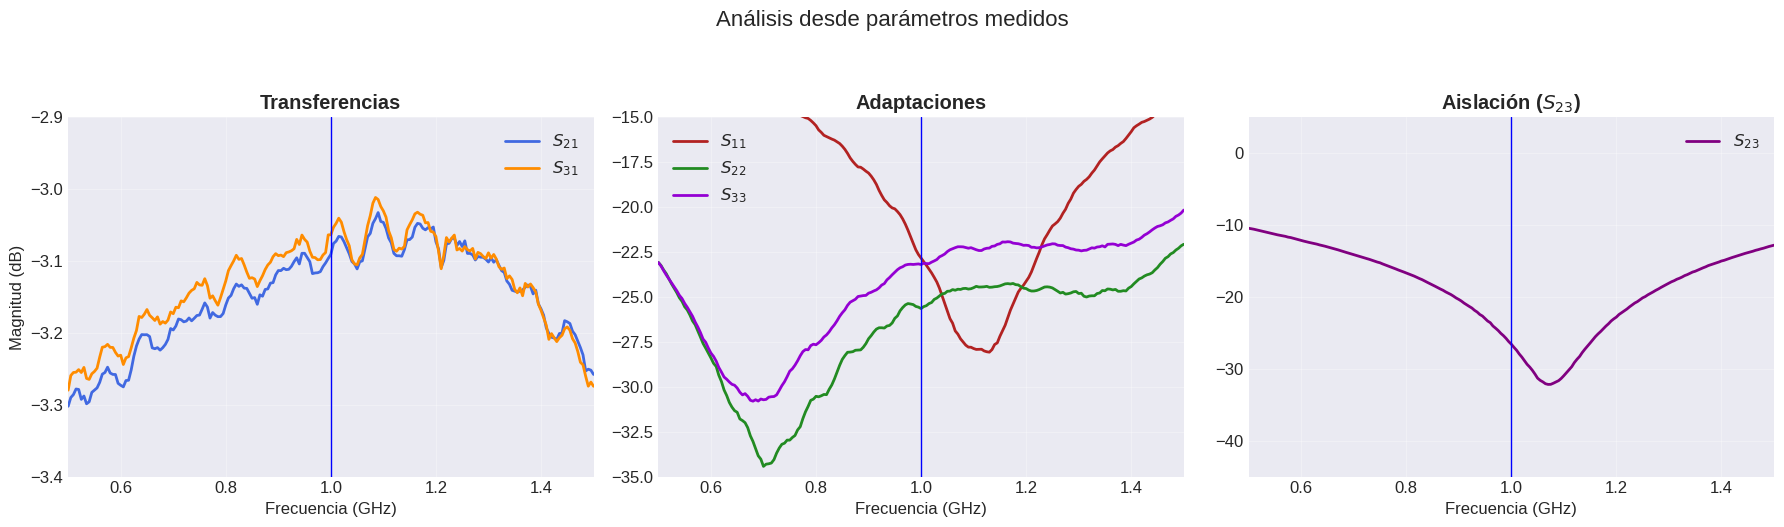

In [7]:
plot_s_parameters(wilkinson, 'Análisis desde parámetros medidos', save_fig=True)

In [ ]:
from importlib import reload

In [ ]:
from importlib import reload
import plotear  # Importa el módulo (no la función directamente)
reload(plotear)  # Recarga el módulo desde disco
from plotear import plot_s_parameters  # Vuelve a importar la función actualizada


In [9]:
ideal = rf.Network('simulaciones/ideal.s3p')

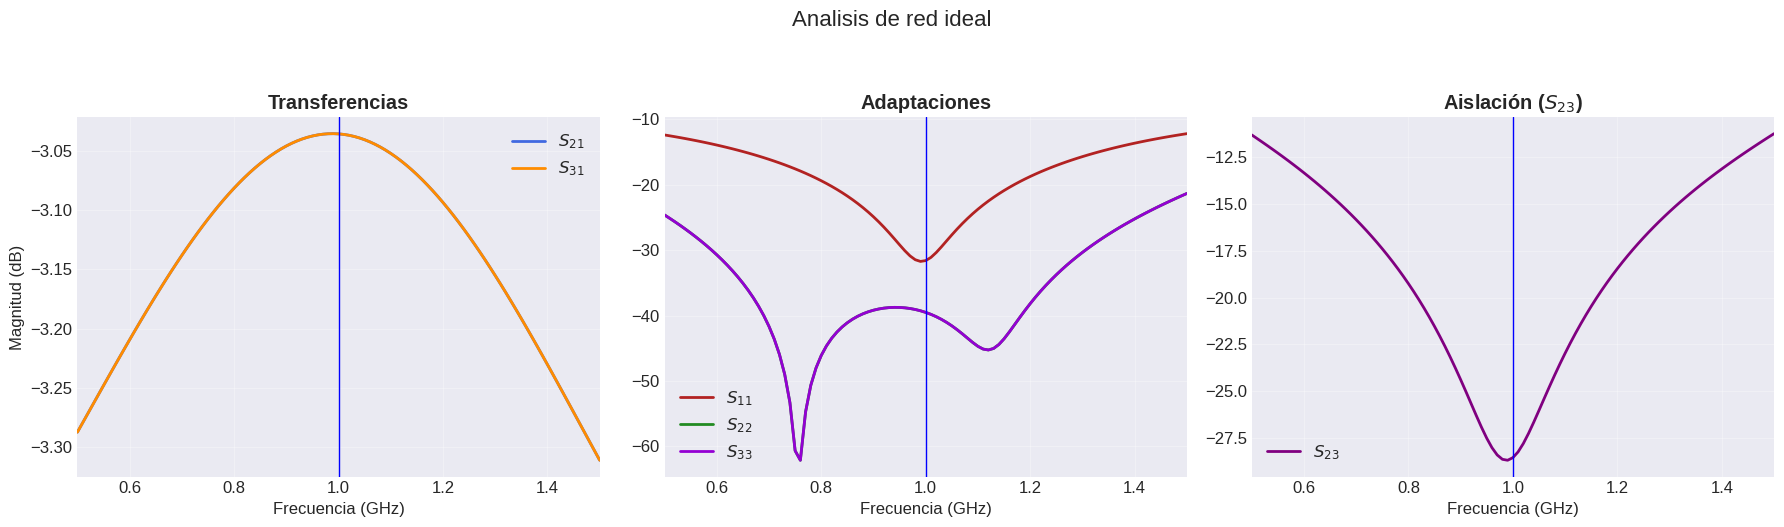

In [13]:
plot_s_parameters(ideal, 'Analisis de red ideal', save_fig=True, autoscales=True)

In [12]:
simulado = rf.Network('simulaciones/simulado.s3p')

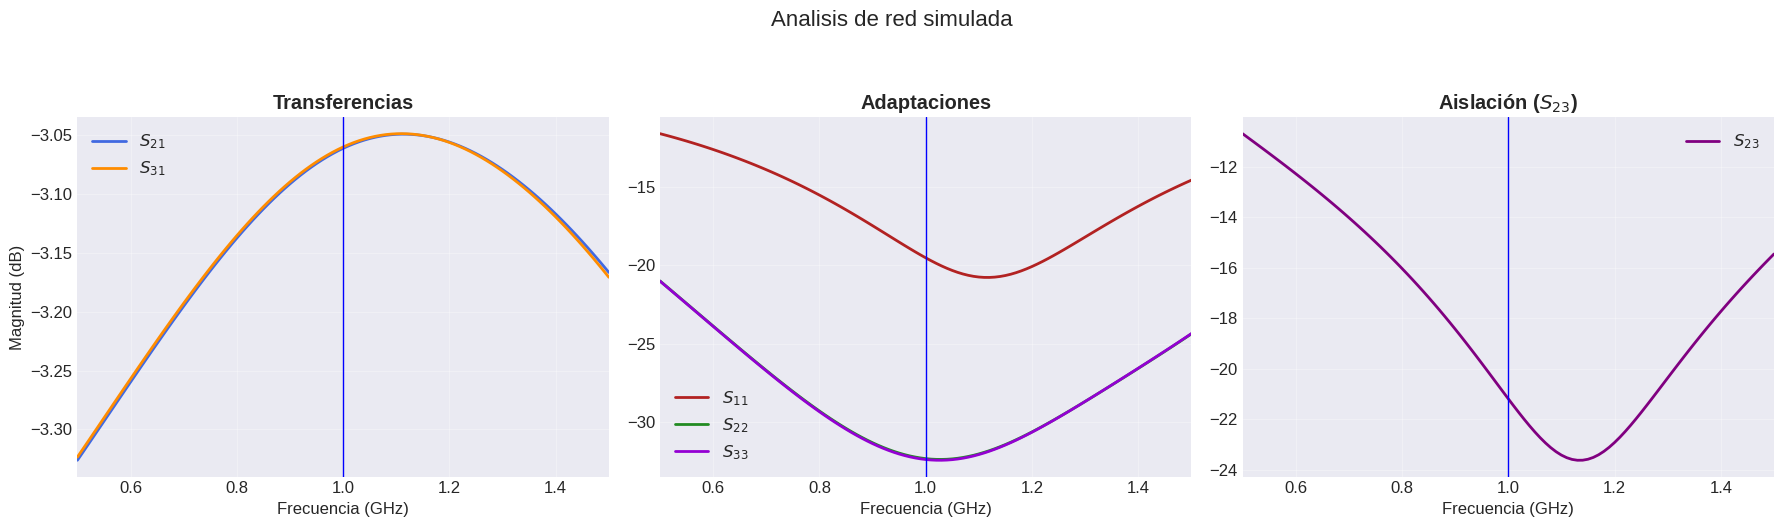

In [14]:
plot_s_parameters(simulado, 'Analisis de red simulada', save_fig=True, autoscales=True)

# Corrección de error de instrumento
Capturamos también los  parámetros `.2sp` de una conexión directa entre los cables para ver el ripple de nuestro setup

In [ ]:
through = rf.Network(frequency = m4.frequency, s = m4.s, z0=50, name='Through')

In [ ]:
through.plot_s_db()

Hay una enorme diferencia entre las transferencias y los rebotes. Concentrandome en las transferencias

In [ ]:
through.plot_s_db(m=1, n=0)
through.plot_s_db(m=0, n=1)

Ajá, acá sí, sin embargo las amplitudes se ven de 0.05 maso. Poco.

Para hacer una nueva red con la corrección aplicada voy a necesitar la correspondiencia de los puertos del VNA originales y los puertos de la red `wilkinson`.<br>
Por ejemplo: La transferencia $S_{31}$ de la red de Wilkinson se corresponde la transferencia $S_{21}$ del archivo `3.s2p`. Entonces, necesitamos hacer $S_{31}(\text{Wilkinson}) \cdot S_{21}^{-1}(\text{VNA})$, es decir, la transfewrencia de la red armada a partir de las mediciónes del dispositivo por el inverso de la transferencia medida en los cables. Las reflexiónes están promediadas; en el caso de $S_{22}$ la re-calculo usando solamente $S_{11}$ de `2.s2p` ya que está medida de dos puertos del VNA distintos. Las otras dos reflexiónes son consistentes. Acá a no errarle.

## Tabla de archivos original

| Archivo | Puerto VNA | Puerto Dispositivo |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

## Correspondencia en corrección

| Wilkinson | Correccion
| --------- | ---------------
| $S_{11}$  | $S_{11}$   |
| $S_{22}$  | $S_{11}$   |
| $S_{33}$  | $S_{22}$   |
| $S_{21}$  | $S_{21}$   |
| $S_{31}$  | $S_{21}$   |
| $S_{23}$  | $S_{12}$   |
| $S_{32}$  | $S_{21}$   |

Invertimos la matriz del through para aplicar las correcciónes

In [ ]:
through.plot_s_db(0, 1)
through.inv.plot_s_db(0, 1)

In [ ]:
correccion = through.inv

In [ ]:
#Re calculo S11
wilkinson.s[:, 0, 0] = m2.s[:, 0, 0]

In [ ]:
wilkinson_fix = wilkinson.copy()

In [ ]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2] * correccion.s[:, 1, 1]
wilkinson_fix.s[:, 1, 0] = wilkinson.s[:, 1, 0] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 2, 1] = wilkinson.s[:, 2, 1] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 1, 2] = wilkinson.s[:, 1, 2] * correccion.s[:, 0, 1]

Taraaann a ver los ploteos corregidos

In [ ]:
# Configuración del estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['font.size'] = 12

# Crear figura con 3 subplots horizontales
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Análisis del Divisor Wilkinson', fontsize=16, y=1.05)

# -----------------------------------------------------------------------------
# Gráfico 1: Transferencias (S21 y S31) - Escala: -3.4 dB a -2.9 dB
# -----------------------------------------------------------------------------
ax1.set_title('Transferencias', fontweight='bold')
ax1.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 1, 0])), label='$S_{21}$', linewidth=2, color='royalblue')
ax1.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 0])), label='$S_{31}$', linewidth=2, color='darkorange')
ax1.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax1.set_xlabel('Frecuencia (GHz)')
ax1.set_ylabel('Magnitud (dB)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-3.4, -2.9)  # Escala ajustada
ax1.set_xlim(0.5, 1.5)    # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 2: Adaptaciones (S11, S22, S33) - Escala: -15 dB a -35 dB
# -----------------------------------------------------------------------------
ax2.set_title('Adaptaciones', fontweight='bold')
ax2.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 0, 0])), label='$S_{11}$', linewidth=2, color='firebrick')
ax2.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 1, 1])), label='$S_{22}$', linewidth=2, color='forestgreen')
ax2.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 2])), label='$S_{33}$', linewidth=2, color='darkviolet')
ax2.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax2.set_xlabel('Frecuencia (GHz)')
ax2.legend()
ax2.grid(True, alpha=0.3)
#ax2.set_ylim(-35, -15)  # Escala ajustada (invertida para mejor visualización)
ax2.set_xlim(0.5, 1.5)  # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 3: Aislación (S23) - Escala: -45 dB a 5 dB
# -----------------------------------------------------------------------------
ax3.set_title('Aislación ($S_{23}$)', fontweight='bold')
ax3.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 1])),
         color='purple', linewidth=2, label='$S_{23}$')
ax3.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax3.set_xlabel('Frecuencia (GHz)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-45, 5)    # Escala ajustada
ax3.set_xlim(0.5, 1.5)  # Frecuencia fija

# Ajustar espaciado y guardar
plt.tight_layout()
#plt.savefig('wilkinson_analysis_scaled.png', dpi=300, bbox_inches='tight')
plt.show()

Las adaptaciónes están exageradas ya que se están sumando los dB de la adaptación original más los de la adaptación del trough (que no da cero) así que las dejo fuera del calculo. Revierto la red corregida para volver las reflexiónes a sus valores originales

In [ ]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2]

In [ ]:
# Configuración del estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 12

# Crear figura con 3 subplots horizontales

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis del Divisor Wilkinson', fontsize=16, y=1.05)

# -----------------------------------------------------------------------------
# Gráfico 1: Transferencias (S21 y S31) - Escala: -3.4 dB a -2.9 dB
# -----------------------------------------------------------------------------
ax1.set_title('Transferencias', fontweight='bold')
ax1.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 1, 0])), label='$S_{21}$', linewidth=2, color='royalblue')
ax1.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 2, 0])), label='$S_{31}$', linewidth=2, color='darkorange')
ax1.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax1.set_xlabel('Frecuencia (GHz)')
ax1.set_ylabel('Magnitud (dB)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-3.4, -2.9)  # Escala ajustada
ax1.set_xlim(0.5, 1.5)    # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 2: Adaptaciones (S11, S22, S33) - Escala: -15 dB a -35 dB
# -----------------------------------------------------------------------------
ax2.set_title('Adaptaciones', fontweight='bold')
ax2.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 0, 0])), label='$S_{11}$', linewidth=2, color='royalblue')
ax2.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 1, 1])), label='$S_{22}$', linewidth=2, color='darkorange')
ax2.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 2, 2])), label='$S_{33}$', linewidth=2, color='firebrick')
ax2.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax2.set_xlabel('Frecuencia (GHz)')
ax2.legend()
ax2.grid(True, alpha=0.3)
#ax2.set_ylim(-35, -15)  # Escala ajustada (invertida para mejor visualización)
ax2.set_xlim(0.5, 1.5)  # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 3: Aislación (S23) - Escala: -45 dB a 5 dB
# -----------------------------------------------------------------------------
ax3.set_title('Aislación ($S_{23}$)', fontweight='bold')
ax3.plot(wilkinson.frequency.f/1e9, 20*np.log10(np.abs(wilkinson.s[:, 2, 1])),
         color='purple', linewidth=2, label='$S_{23}$')
ax3.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax3.set_xlabel('Frecuencia (GHz)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-45, 5)    # Escala ajustada
ax3.set_xlim(0.5, 1.5)  # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 4: Transferencias (S21 y S31) - Escala: -3.4 dB a -2.9 dB
# -----------------------------------------------------------------------------
ax4.set_title('Transferencias (corregido)', fontweight='bold')
ax4.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 1, 0])), label='$S_{21}$', linewidth=2, color='royalblue')
ax4.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 0])), label='$S_{31}$', linewidth=2, color='darkorange')
ax4.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax4.set_xlabel('Frecuencia (GHz)')
ax4.set_ylabel('Magnitud (dB)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-3.4, -2.9)  # Escala ajustada
ax4.set_xlim(0.5, 1.5)    # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 5: Adaptaciones (S11, S22, S33) - Escala: -15 dB a -35 dB
# -----------------------------------------------------------------------------
ax5.set_title('Adaptaciones', fontweight='bold')
ax5.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 0, 0])), label='$S_{11}$', linewidth=2, color='royalblue')
ax5.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 1, 1])), label='$S_{22}$', linewidth=2, color='darkorange')
ax5.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 2])), label='$S_{33}$', linewidth=2, color='firebrick')
ax5.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax5.set_xlabel('Frecuencia (GHz)')
ax5.legend()
ax5.grid(True, alpha=0.3)
#ax2.set_ylim(-35, -15)  # Escala ajustada (invertida para mejor visualización)
ax5.set_xlim(0.5, 1.5)  # Frecuencia fija

# -----------------------------------------------------------------------------
# Gráfico 6: Aislación (S23) - Escala: -45 dB a 5 dB
# -----------------------------------------------------------------------------
ax6.set_title('Aislación ($S_{23}$, corregido)', fontweight='bold')
ax6.plot(wilkinson_fix.frequency.f/1e9, 20*np.log10(np.abs(wilkinson_fix.s[:, 2, 1])),
         color='purple', linewidth=2, label='$S_{23}$')
ax6.axvline(1.0, color='blue', linewidth=1)  # Línea vertical en 1 GHz
ax6.set_xlabel('Frecuencia (GHz)')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim(-45, 5)    # Escala ajustada
ax6.set_xlim(0.5, 1.5)  # Frecuencia fija


# Ajustar espaciado y guardar
plt.tight_layout()
#plt.savefig('wilkinson_analysis_scaled.png', dpi=300, bbox_inches='tight')
plt.show()

Para probar la correccion, necesito red de 2 puertos de wilkinson; genero `wilkinson_12` para los parámetros S de los puertos 1 y 2 de Wilkinson (que no es lo mismo que $S_{21}$)

In [ ]:
wilkinson.plot_s_db()

In [ ]:
wilkinson_12 = wilkinson.subnetwork([0, 1])

In [ ]:
wilkinson_12_fix = wilkinson_12 * correccion

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(wilkinson.frequency.f/1e9, 20 * np.log10(np.abs(wilkinson.s[:, 1, 0])),
         label='$S_{21}$ (Original)', color='blue', linewidth=2)
plt.plot(wilkinson.frequency.f/1e9, 20 * np.log10(np.abs(wilkinson_12_fix.s[:, 1, 0])),
         label='$S_{21}$ (Corregido)', color='red', linestyle='--', linewidth=2)
plt.plot(wilkinson.frequency.f/1e9, 20 * np.log10(np.abs(correccion.s[:, 1, 0]))-2.7,
         label='Trough (inv)', color='red', linestyle='-', linewidth=1)
plt.plot(wilkinson.frequency.f/1e9, 20 * np.log10(np.abs(through.s[:, 1, 0]))-2.7,
         label='Trough', color='blue', linestyle='-', linewidth=1)

# Personalización
plt.title("Comparación de $S_{21}$: Original vs. Corregido", fontsize=14)
plt.xlabel("Frecuencia (GHz)", fontsize=12)
plt.ylabel("Magnitud (dB)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.7)
plt.ylim(-3.5, -2.5)
plt.tight_layout()
plt.show()